Este notebook será una extensión y modificación del anterior. Por este motivo, el formato podría ser ligeramente similar. El principal cambio que se le hará, es el de modificar el soporte a la hora de instanciar las caritas. Además, se cambiará el número de datos $\{x_i\}_{i=1}^{n}$ con $n=10$ en vez de $n=3$ como en el notebook anterior.

# Imports y configuraciones iniciales

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from bwb.distributions import DistributionDraw, DistributionDrawBuilder
from bwb.utils import plot_list_of_draws, plot_histogram_from_points

Importamos los datos utilizando el archivo npy que proporciona Google Cloud.

In [2]:
data = np.load(r"..\data\face.npy")
data.shape

(161666, 784)

Hacemos una lista de caritas, fijando un generador con la semilla 42 para tener resultados replicables.

In [3]:
%%time
CEIL = 50

rng = np.random.default_rng(42)
faces: list[DistributionDraw] = list()
n_faces = len(data)

dist_draw_builder = DistributionDrawBuilder(seed=rng, ceil=CEIL)

for i in range(n_faces):
    arr = 255 - data[i, :].reshape(28, 28)
    dd_arr = dist_draw_builder.create_fromarray(arr)
    faces.append(dd_arr)

CPU times: total: 5.91 s
Wall time: 5.91 s


In [4]:
plot_list_of_draws(faces)

Observamos la primera carita

In [5]:
faces[0].image

Observamos un histograma de esta carita, para ver si se tiene el comportamiento es el deseado.

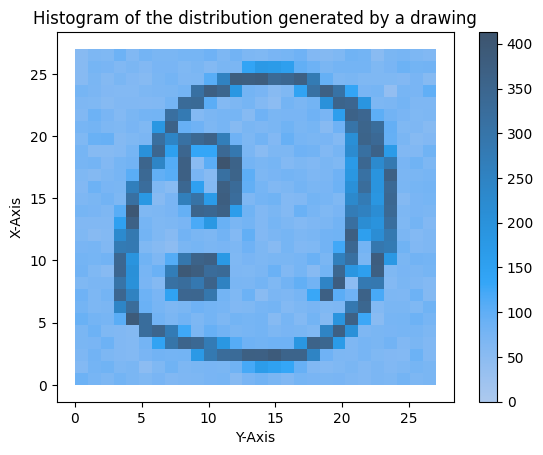

In [6]:
x = np.array(faces[0].rvs(100_000))
plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Por lo que parece, sí tiene soporte distinto de 0.

Muestrear con respecto a una carita (la primera para simplificar) para obtener $D = \{x_i\}_{i=1}^{n}\subseteq\mathcal{X}^n$

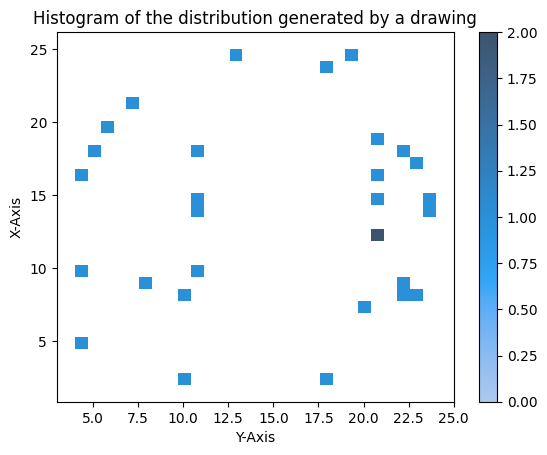

In [7]:
n = 30

first_face = DistributionDraw.fromarray(255 - data[0, :].reshape(28, 28),
                                        seed=42)

x = first_face.rvs(size=n)

plot_histogram_from_points(x, histplot_kwargs=dict(bins=28))
plt.show()

Defino
\begin{equation}
\tilde\Lambda_n(m) = \prod_{i=1}^{n} f_m(x_i)
\end{equation}

A través de la función `likelihood`

In [8]:
def likelihood(mu: DistributionDraw, data: list[tuple[int, int]]):
    evaluations = []
    for i in range(len(data)):
        evaluations.append(mu.matrix[data[i]])
    return np.prod(evaluations)

likelihood(mu=faces[0], data=x)

8.154492671600373e-78

# Metropolis Algorithm

En esta sección se implementa el *Metropolis Algorithm*. Este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = (\text{degr}(\mu))^{-1} = \frac{1}{|\mathcal{M} - 1|}
\end{equation}
donde lo último es por la forma que posee el grafo escogido.

In [9]:
%%time
# Calcular las distintas verosmilitudes como caché
likelihood_cache = np.array([likelihood(face, data=x) for face in faces])

probabilities = (likelihood_cache > 0).astype(float)
probabilities /= probabilities.sum()

CPU times: total: 10.3 s
Wall time: 29.7 s


In [10]:
%%time

N = 1_000  # 10_000
mu = []

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces, p=probabilities))
mu.append(faces[current_face])  # mu^(0)
visited_faces = [faces[current_face]]

# Paso 2.
for i in range(N):
    print("=" * 10)

    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    possible_faces = list(range(n_faces))
    possible_faces.remove(current_face)
    # Escoger una carita
    next_face = int(rng.choice(possible_faces))
    mu_star = faces[next_face]
    if next_face not in likelihood_cache: likelihood_cache[next_face] = likelihood(mu_star, data=x)

    # Paso c.
    # Luego calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1., (likelihood_cache[next_face])
                         / (likelihood_cache[current_face])
                         )

    print(f"{i = }")
    print(f"{likelihood_cache[current_face] = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

        mu.append(mu_star)
        # Moverse a la siguiente carita
        current_face = next_face
        visited_faces.append(mu_star)

    else:
        mu.append(mu[i])


i = 0
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.012565206443017733
i = 1
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.0001800869032654362
i = 2
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.0002474658157605525
i = 3
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 2.6363147498483997e-06
i = 4
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 1.9194544701657728e-07
i = 5
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.03359121405186879
i = 6
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.00011170387386327433
i = 7
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.0019520941717424615
i = 8
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 4.715633534721729e-06
i = 9
likelihood_cache[current_face] = 6.297633436353317e-85
A_mu_i_mu_star = 0.03668082829217898
i 

i = 74
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.380309062920411e-08
i = 75
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.8559498341037405e-07
i = 76
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.804067298506402e-05
i = 77
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.387820132625615e-07
i = 78
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.72345953202153e-07
i = 79
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 7.737940270994447e-05
i = 80
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.857318926070703e-07
i = 81
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.2987827704524434e-08
i = 82
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.699853475787236e-09
i = 83
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 9

i = 156
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.455306694451043e-05
i = 157
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.44456468277184e-09
i = 158
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.604668076698548e-05
i = 159
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.066871035672101e-08
i = 160
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.8573395999267572e-08
i = 161
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.6896442601263168e-08
i = 162
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.287282164859588e-07
i = 163
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.5131591018209217e-05
i = 164
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.3942900754029035e-07
i = 165
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i

i = 243
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.250529780329481e-07
i = 244
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.9860731666542175e-06
i = 245
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.175747161030603e-06
i = 246
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.009758620090265582
i = 247
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.5533279453250034e-08
i = 248
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.382787456758385e-10
i = 249
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 7.982423487252253e-09
i = 250
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.00040617052516512094
i = 251
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.578568397399655e-08
i = 252
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_

i = 330
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.714630526293708e-08
i = 331
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.0665636639112536e-06
i = 332
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.1244776559319284e-10
i = 333
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.3291936871112507e-08
i = 334
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.409226817402544e-06
i = 335
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.7619476339789587e-11
i = 336
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.6417446522217475e-09
i = 337
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.4049848982001348e-09
i = 338
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.5487216081145308e-06
i = 339
likelihood_cache[current_face] = 1.7038226240480013e-81
A_

i = 412
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.1878919881976847e-09
i = 413
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.001321246566215112
i = 414
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.21426247086609465
i = 415
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.3833129635615569e-05
i = 416
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.436975994092418e-11
i = 417
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.7447070119758583e-07
i = 418
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.374771168005933e-06
i = 419
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.1951322820673976e-08
i = 420
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.491805278407849e-05
i = 421
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_m

i = 500
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.0002526437977796775
i = 501
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.2541277412525092e-10
i = 502
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.403408279375311e-08
i = 503
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.639624938054233e-06
i = 504
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.103869386565475e-06
i = 505
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.009928503687173088
i = 506
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 6.690468170455027e-09
i = 507
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.750068618264433e-10
i = 508
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.784648000809119e-07
i = 509
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu

i = 584
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.279354369030101e-05
i = 585
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.2739709198525188e-07
i = 586
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 7.86605249615466e-10
i = 587
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.2934841018533636e-05
i = 588
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.579418989146031e-05
i = 589
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.4240130863214276e-05
i = 590
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.8085688762084996e-08
i = 591
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 7.994588646687345e-11
i = 592
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 1.1884785394064993e-05
i = 593
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_

i = 665
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.0008222632435946911
i = 666
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.412524285881929e-08
i = 667
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 6.67560022099871e-07
i = 668
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 5.388154060431186e-06
i = 669
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 7.511432879563365e-05
i = 670
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.687513435791371e-07
i = 671
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.017530625199057192
i = 672
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 9.804839528632765e-07
i = 673
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.559408462775952e-07
i = 674
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_s

i = 749
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 2.195323502107179e-05
i = 750
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.8146070757869323e-07
i = 751
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.334935816805977e-08
i = 752
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 8.900248012918226e-06
i = 753
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 4.1589057599087544e-10
i = 754
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.0004356715329674616
i = 755
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 0.00014556488335175783
i = 756
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 3.039755427348122e-09
i = 757
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i_mu_star = 6.426327034474314e-05
i = 758
likelihood_cache[current_face] = 1.7038226240480013e-81
A_mu_i

i = 836
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 4.7994045724774134e-05
i = 837
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 8.984386157518313e-06
i = 838
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 8.765165781595005e-06
i = 839
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 1.5962543082605938e-06
i = 840
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 2.1450017370341555e-10
i = 841
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 0.06969644068584535
i = 842
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 8.902004398107225e-06
i = 843
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 5.263044706747806e-07
i = 844
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_mu_star = 3.143908810398989e-05
i = 845
likelihood_cache[current_face] = 1.7099317557366402e-82
A_mu_i_m

i = 908
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 8.716038146486873e-08
i = 909
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.0705035301221628e-09
i = 910
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.4639423747472887e-07
i = 911
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 8.633958508353387e-08
i = 912
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 8.818610957100335e-09
i = 913
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.0941766527929288e-09
i = 914
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 5.089510363331627e-07
i = 915
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 2.9522757628928503e-06
i = 916
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 5.41607758292071e-07
i = 917
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star =

i = 989
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 8.451921154517118e-09
i = 990
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.801494328077388e-05
i = 991
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 9.048747024906231e-07
i = 992
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 0.017684929989565952
i = 993
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 3.7371630856386337e-10
i = 994
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.2447050292626576e-10
i = 995
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 7.681900821091649e-09
i = 996
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 0.00023266568370425362
i = 997
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star = 1.5630616770953303e-06
i = 998
likelihood_cache[current_face] = 3.895467459158051e-82
A_mu_i_mu_star =

Empecemos observando las distintas imágenes que generó

In [11]:
len(visited_faces)

7

In [12]:
# Primera imagen generada
mu[0].image

In [13]:
plot_list_of_draws(visited_faces)

In [14]:
# Última imagen generada
mu[-1].image

# Gibbs Sampler

Ahora empecemos a generar la otra variación del algoritmo: *Gibbs Sampler*. Después de unos cálculos, este posee la siguiente matriz $R$:
\begin{equation}
R_{\mu, \nu} = \frac{
\tilde \Lambda_n(\nu)
}{
\sum_{\tilde \nu \in \mathcal{M}} \tilde \Lambda_n(\tilde \nu) - \tilde \Lambda_n(\mu)
}
\end{equation}
con la función $\tilde\Lambda_n$ definida como antes.

Notemos que, la gran diferencia con el otro algoritmo es la forma de calcular la matriz $R$. Por este motivo se copiará y pegará el algoritmo anterior, modificando este valor.

In [15]:
%%time
likelihood_cache = np.array([likelihood(nu_tilde, data=x) for nu_tilde in faces])
# Cálculo de la sumatoria, que es un valor genérico para todos
sum_lambdas_n = sum(likelihood_cache)
sum_lambdas_n

CPU times: total: 3.72 s
Wall time: 22.1 s


1.3241917735850136e-77

In [16]:
sum(likelihood_cache > 0)

161666

In [17]:
%%time

N = 1_000
mu = []
possible_faces = list(range(n_faces))

# Paso 1. Empezar con una distribución inicial mu^(0) \in M
current_face = int(rng.choice(n_faces))
mu.append(faces[current_face])  # mu^(0)
probabilities = dict()

# Paso 2.
for i in range(N):
    print("=" * 10)
    # Paso a. muestrear u ~ U[0, 1]
    u = rng.uniform(low=0, high=1)

    # Paso b. muestrear mu^star de acuerdo a R partiendo desde mu^(i)
    # Calcular las probabilidades
    if current_face not in probabilities:
        print(f"Calculando las probabilidades de transición de la carita {current_face = }")
        probabilities[current_face] = np.array([
            likelihood_cache[face_i]
            / (sum_lambdas_n - likelihood_cache[current_face]) for face_i in possible_faces
        ])
        probabilities[current_face][current_face] = 0.
    # Escoger una carita
    next_face = int(rng.choice(possible_faces, p=probabilities[current_face]))
    mu_star = faces[next_face]

    # Paso c.
    # calculamos la probabilidad de aceptación
    A_mu_i_mu_star = min(1., (sum_lambdas_n - likelihood_cache[current_face])
                         / (sum_lambdas_n - likelihood_cache[next_face])
                         )

    print(f"{i = }")
    print(f"{A_mu_i_mu_star = }")
    if u < A_mu_i_mu_star:
        print(f"{current_face = } -> {next_face = }")
        print(f"{u = }")

        mu.append(mu_star)
        # Moverse a la siguiente carita
        current_face = next_face

    else:
        mu.append(mu[i])


Calculando las probabilidades de transición de la carita current_face = 113590
i = 0
A_mu_i_mu_star = 1.0
current_face = 113590 -> next_face = 11405
u = 0.7506742488554872
Calculando las probabilidades de transición de la carita current_face = 11405
i = 1
A_mu_i_mu_star = 1.0
current_face = 11405 -> next_face = 0
u = 0.6708092916489998
Calculando las probabilidades de transición de la carita current_face = 0
i = 2
A_mu_i_mu_star = 0.384196320825582
i = 3
A_mu_i_mu_star = 0.39671435576315056
i = 4
A_mu_i_mu_star = 0.3855804252098216
current_face = 0 -> next_face = 100140
u = 0.24412692789109391
Calculando las probabilidades de transición de la carita current_face = 100140
i = 5
A_mu_i_mu_star = 1.0
current_face = 100140 -> next_face = 0
u = 0.7327439953441194
i = 6
A_mu_i_mu_star = 0.38748122649485467
i = 7
A_mu_i_mu_star = 0.3845721346300738
i = 8
A_mu_i_mu_star = 0.3842123681905177
i = 9
A_mu_i_mu_star = 0.3843163016688742
i = 10
A_mu_i_mu_star = 0.39617520640290954
i = 11
A_mu_i_mu_s

i = 83
A_mu_i_mu_star = 1.0
current_face = 140937 -> next_face = 0
u = 0.48729537177292337
i = 84
A_mu_i_mu_star = 0.39100075930235245
i = 85
A_mu_i_mu_star = 0.3842976711913146
i = 86
A_mu_i_mu_star = 0.3841962016954422
current_face = 0 -> next_face = 61521
u = 0.12075541081769636
Calculando las probabilidades de transición de la carita current_face = 61521
i = 87
A_mu_i_mu_star = 1.0
current_face = 61521 -> next_face = 66778
u = 0.6309590656220361
Calculando las probabilidades de transición de la carita current_face = 66778
i = 88
A_mu_i_mu_star = 1.0
current_face = 66778 -> next_face = 0
u = 0.4320320985661945
i = 89
A_mu_i_mu_star = 0.3842679674666022
current_face = 0 -> next_face = 2710
u = 0.08990523183273802
Calculando las probabilidades de transición de la carita current_face = 2710
i = 90
A_mu_i_mu_star = 1.0
current_face = 2710 -> next_face = 0
u = 0.23437320896865144
i = 91
A_mu_i_mu_star = 0.3848461130510917
i = 92
A_mu_i_mu_star = 0.39671435576315056
i = 93
A_mu_i_mu_star 

i = 172
A_mu_i_mu_star = 1.0
current_face = 24257 -> next_face = 142502
u = 0.6810805076574876
i = 173
A_mu_i_mu_star = 1.0
current_face = 142502 -> next_face = 0
u = 0.4305988034408442
i = 174
A_mu_i_mu_star = 0.38472172347568945
current_face = 0 -> next_face = 93190
u = 0.17972737964895225
Calculando las probabilidades de transición de la carita current_face = 93190
i = 175
A_mu_i_mu_star = 1.0
current_face = 93190 -> next_face = 0
u = 0.6873380998979365
i = 176
A_mu_i_mu_star = 0.384769833075316
current_face = 0 -> next_face = 50907
u = 0.04245091041582527
Calculando las probabilidades de transición de la carita current_face = 50907
i = 177
A_mu_i_mu_star = 0.9985208628563612
current_face = 50907 -> next_face = 91732
u = 0.08255738708235683
Calculando las probabilidades de transición de la carita current_face = 91732
i = 178
A_mu_i_mu_star = 1.0
current_face = 91732 -> next_face = 0
u = 0.8793347918645756
i = 179
A_mu_i_mu_star = 0.39551997759705027
current_face = 0 -> next_face = 1

i = 260
A_mu_i_mu_star = 1.0
current_face = 51491 -> next_face = 0
u = 0.4548178354321566
i = 261
A_mu_i_mu_star = 0.39617520640290954
i = 262
A_mu_i_mu_star = 0.3842138924366524
i = 263
A_mu_i_mu_star = 0.38423032469267293
i = 264
A_mu_i_mu_star = 0.3918271117129066
i = 265
A_mu_i_mu_star = 0.38799140085198974
i = 266
A_mu_i_mu_star = 0.384202835881251
current_face = 0 -> next_face = 14024
u = 0.10463372459331599
Calculando las probabilidades de transición de la carita current_face = 14024
i = 267
A_mu_i_mu_star = 1.0
current_face = 14024 -> next_face = 28549
u = 0.6906106239701281
i = 268
A_mu_i_mu_star = 0.9685877471092005
current_face = 28549 -> next_face = 109797
u = 0.8422733987843248
Calculando las probabilidades de transición de la carita current_face = 109797
i = 269
A_mu_i_mu_star = 1.0
current_face = 109797 -> next_face = 0
u = 0.4788006508586149
i = 270
A_mu_i_mu_star = 0.3842732339967788
i = 271
A_mu_i_mu_star = 0.3845798718918211
current_face = 0 -> next_face = 136330
u =

i = 341
A_mu_i_mu_star = 0.39551997759705027
i = 342
A_mu_i_mu_star = 0.38582144230610343
i = 343
A_mu_i_mu_star = 0.39100075930235245
i = 344
A_mu_i_mu_star = 0.39671435576315056
i = 345
A_mu_i_mu_star = 0.39551997759705027
current_face = 0 -> next_face = 112656
u = 0.022932569442168038
i = 346
A_mu_i_mu_star = 0.9787297566858133
current_face = 112656 -> next_face = 74415
u = 0.3363711274074962
i = 347
A_mu_i_mu_star = 1.0
current_face = 74415 -> next_face = 112656
u = 0.7718115546022893
i = 348
A_mu_i_mu_star = 0.9716428893593997
current_face = 112656 -> next_face = 104229
u = 0.4854215148787169
Calculando las probabilidades de transición de la carita current_face = 104229
i = 349
A_mu_i_mu_star = 1.0
current_face = 104229 -> next_face = 134930
u = 0.6600497551905223
i = 350
A_mu_i_mu_star = 1.0
current_face = 134930 -> next_face = 28549
u = 0.46556066188358847
i = 351
A_mu_i_mu_star = 0.9725421747441112
current_face = 28549 -> next_face = 94176
u = 0.24918056004203804
Calculando las

i = 429
A_mu_i_mu_star = 0.3848714482656203
i = 430
A_mu_i_mu_star = 0.3844002377217888
current_face = 0 -> next_face = 140186
u = 0.22622158354804256
Calculando las probabilidades de transición de la carita current_face = 140186
i = 431
A_mu_i_mu_star = 1.0
current_face = 140186 -> next_face = 0
u = 0.5395944535407144
i = 432
A_mu_i_mu_star = 0.3871071714379393
i = 433
A_mu_i_mu_star = 0.39617520640290954
i = 434
A_mu_i_mu_star = 0.39551997759705027
i = 435
A_mu_i_mu_star = 0.39671435576315056
i = 436
A_mu_i_mu_star = 0.38697575795512706
current_face = 0 -> next_face = 71039
u = 0.2846778284008006
i = 437
A_mu_i_mu_star = 1.0
current_face = 71039 -> next_face = 0
u = 0.2534341139933858
i = 438
A_mu_i_mu_star = 0.38419318364069865
i = 439
A_mu_i_mu_star = 0.38428974127867893
i = 440
A_mu_i_mu_star = 0.3841939601057982
i = 441
A_mu_i_mu_star = 0.39671435576315056
i = 442
A_mu_i_mu_star = 0.3918271117129066
current_face = 0 -> next_face = 134930
u = 0.31155350178315167
i = 443
A_mu_i_mu_

i = 533
A_mu_i_mu_star = 0.39617520640290954
current_face = 0 -> next_face = 142502
u = 0.13202190708580042
i = 534
A_mu_i_mu_star = 0.9698008690740062
current_face = 142502 -> next_face = 74038
u = 0.763954750899601
Calculando las probabilidades de transición de la carita current_face = 74038
i = 535
A_mu_i_mu_star = 1.0
current_face = 74038 -> next_face = 8551
u = 0.40580896245748177
Calculando las probabilidades de transición de la carita current_face = 8551
i = 536
A_mu_i_mu_star = 1.0
current_face = 8551 -> next_face = 147386
u = 0.694073010464386
i = 537
A_mu_i_mu_star = 1.0
current_face = 147386 -> next_face = 0
u = 0.5551522126400975
i = 538
A_mu_i_mu_star = 0.38428856291132596
current_face = 0 -> next_face = 46044
u = 0.11966716563860502
Calculando las probabilidades de transición de la carita current_face = 46044
i = 539
A_mu_i_mu_star = 1.0
current_face = 46044 -> next_face = 0
u = 0.02541218788225108
i = 540
A_mu_i_mu_star = 0.3842353034270315
i = 541
A_mu_i_mu_star = 0.384

i = 626
A_mu_i_mu_star = 0.9990383375028836
current_face = 50404 -> next_face = 139520
u = 0.4434902540933595
i = 627
A_mu_i_mu_star = 1.0
current_face = 139520 -> next_face = 0
u = 0.9688500141244224
i = 628
A_mu_i_mu_star = 0.3918271117129066
current_face = 0 -> next_face = 134930
u = 0.1488967313223628
i = 629
A_mu_i_mu_star = 1.0
current_face = 134930 -> next_face = 0
u = 0.3312617567451278
i = 630
A_mu_i_mu_star = 0.3850657162459912
i = 631
A_mu_i_mu_star = 0.3844804423096026
current_face = 0 -> next_face = 69664
u = 0.05383531740138647
Calculando las probabilidades de transición de la carita current_face = 69664
i = 632
A_mu_i_mu_star = 1.0
current_face = 69664 -> next_face = 40131
u = 0.21593575892603745
i = 633
A_mu_i_mu_star = 1.0
current_face = 40131 -> next_face = 0
u = 0.9865782373472556
i = 634
A_mu_i_mu_star = 0.38566046752841077
i = 635
A_mu_i_mu_star = 0.39617520640290954
current_face = 0 -> next_face = 142502
u = 0.14797146682062134
i = 636
A_mu_i_mu_star = 1.0
current

i = 727
A_mu_i_mu_star = 0.39551997759705027
i = 728
A_mu_i_mu_star = 0.39617520640290954
current_face = 0 -> next_face = 142502
u = 0.3005086694201815
i = 729
A_mu_i_mu_star = 1.0
current_face = 142502 -> next_face = 28549
u = 0.9126484176679894
i = 730
A_mu_i_mu_star = 0.9692279764210727
current_face = 28549 -> next_face = 5848
u = 0.5783243376684982
Calculando las probabilidades de transición de la carita current_face = 5848
i = 731
A_mu_i_mu_star = 1.0
current_face = 5848 -> next_face = 0
u = 0.38098589204808964
i = 732
A_mu_i_mu_star = 0.39100075930235245
i = 733
A_mu_i_mu_star = 0.3842404213355527
current_face = 0 -> next_face = 99443
u = 0.27681853539997126
Calculando las probabilidades de transición de la carita current_face = 99443
i = 734
A_mu_i_mu_star = 1.0
current_face = 99443 -> next_face = 0
u = 0.6589733907378407
i = 735
A_mu_i_mu_star = 0.38697575795512706
current_face = 0 -> next_face = 71039
u = 0.21081657966441025
i = 736
A_mu_i_mu_star = 0.9937500864275115
current_

i = 819
A_mu_i_mu_star = 0.38420941342090636
current_face = 0 -> next_face = 107885
u = 0.3453178258803078
Calculando las probabilidades de transición de la carita current_face = 107885
i = 820
A_mu_i_mu_star = 1.0
current_face = 107885 -> next_face = 0
u = 0.6608829589201736
i = 821
A_mu_i_mu_star = 0.3868990027011373
i = 822
A_mu_i_mu_star = 0.3841950309677536
current_face = 0 -> next_face = 217
u = 0.13350979105453886
Calculando las probabilidades de transición de la carita current_face = 217
i = 823
A_mu_i_mu_star = 1.0
current_face = 217 -> next_face = 142502
u = 0.45856050825236827
i = 824
A_mu_i_mu_star = 1.0
current_face = 142502 -> next_face = 0
u = 0.8631209319327676
i = 825
A_mu_i_mu_star = 0.3842273320831569
current_face = 0 -> next_face = 80245
u = 0.14744688873880052
Calculando las probabilidades de transición de la carita current_face = 80245
i = 826
A_mu_i_mu_star = 1.0
current_face = 80245 -> next_face = 69943
u = 0.985614423630127
i = 827
A_mu_i_mu_star = 1.0
current_

i = 917
A_mu_i_mu_star = 1.0
current_face = 79011 -> next_face = 0
u = 0.5842475027440451
i = 918
A_mu_i_mu_star = 0.38566046752841077
current_face = 0 -> next_face = 114248
u = 0.2848064445796046
i = 919
A_mu_i_mu_star = 1.0
current_face = 114248 -> next_face = 0
u = 0.19995208615251792
i = 920
A_mu_i_mu_star = 0.38431071890065804
i = 921
A_mu_i_mu_star = 0.38566046752841077
current_face = 0 -> next_face = 114248
u = 0.37798003545415815
i = 922
A_mu_i_mu_star = 1.0
current_face = 114248 -> next_face = 0
u = 0.28249315238052475
i = 923
A_mu_i_mu_star = 0.38419762082619624
i = 924
A_mu_i_mu_star = 0.3868990027011373
current_face = 0 -> next_face = 147386
u = 0.339778702905025
i = 925
A_mu_i_mu_star = 1.0
current_face = 147386 -> next_face = 0
u = 0.26332880239851364
i = 926
A_mu_i_mu_star = 0.3844911350131891
current_face = 0 -> next_face = 154677
u = 0.105278779056724
Calculando las probabilidades de transición de la carita current_face = 154677
i = 927
A_mu_i_mu_star = 1.0
current_fac

In [18]:
not_none_keys = probabilities.keys()

len(not_none_keys)

143

Empecemos observando las distintas imágenes que generó

In [19]:
# Primera imagen generada
mu[0].image

In [20]:
plot_list_of_draws([faces[k] for k in not_none_keys])

In [21]:
# Última imagen generada
mu[-1].image